In [382]:
import warnings

import h2o
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from h2o.automl import H2OAutoML
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

warnings.filterwarnings("ignore")

In [383]:
# Carga de datos
df_survey = pd.read_pickle(filepath_or_buffer="data/df_survey.pkl")
y = "covid19"
ignore = ["covid19"]
x = list(set(df_survey.columns) - set(ignore))

In [384]:
# Define the numeric and categorical features
numeric_features = [
    "id_bio_age",
    "id_bio_weight",
    "id_bio_height",
    "id_mat_18_plus_household_members",
    "id_mat_total_household_members",
]
categorical_features = list(set(x) - set(numeric_features))

# scaler = StandardScaler()
# df_survey_imputed_num = pd.DataFrame(
#     scaler.fit_transform(df_survey[x]), columns=x)
# imputer = KNNImputer(n_neighbors=10)
# df_survey_imputed_num = pd.DataFrame(
#     imputer.fit_transform(df_survey[numeric_features]), columns=numeric_features
# )
# df_survey_imputed_num = df_survey_imputed_num[numeric_features]
# df_survey_imputed_num = pd.DataFrame(
#     imputer.fit_transform(df_survey_imputed_num), columns=df_survey_imputed_num.columns
# )

imputer = SimpleImputer(strategy="mean")
df_survey_imputed_num = pd.DataFrame(
    imputer.fit_transform(df_survey[numeric_features]), columns=numeric_features
)
df_survey_imputed_num = df_survey_imputed_num[numeric_features]

# Define the transformers for numeric and categorical features
# numeric_transformer = Pipeline(
#     # steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
#     steps=[("imputer", KNNImputer(n_neighbors=5)), ("scaler", StandardScaler())]
# )

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        # ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Fit and transform the data
df_survey_imputed_cat = preprocessor.fit_transform(df_survey[x])

df_survey_imputed = pd.DataFrame(
    np.concatenate([df_survey_imputed_num, df_survey_imputed_cat], axis=1),
    columns=numeric_features + categorical_features,
)

df_survey_imputed.head()

,id_bio_age,id_bio_weight,id_bio_height,id_mat_18_plus_household_members,id_mat_total_household_members,id_bio_disability,sd_occ_current_job,id_bio_bubble_contag,sd_inc_income_problems,id_bio_vacc_status,...,id_bio_death_covid,sd_eth_is_costa_rican,id_beh_percep_severity,id_bio_gender,id_psy_vacc_myths,sd_inc_income_level,sd_cul_holiday_season,sd_edu_scholarity,id_beh_risk_others,id_bio_out_bubble_contag
0,52.0,83.0,178.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0
1,68.0,68.0,171.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0
2,36.0,90.0,171.0,2.0,3.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0
3,78.0,57.0,150.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,2.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0
4,20.0,78.0,180.0,5.0,5.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0


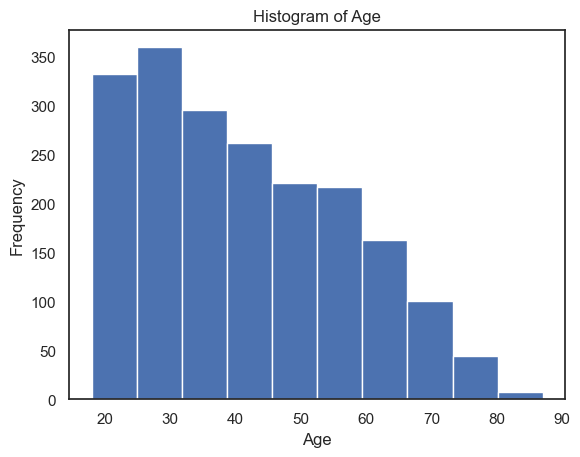

In [385]:
plt.hist(df_survey_imputed.id_bio_age)
plt.title("Histogram of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

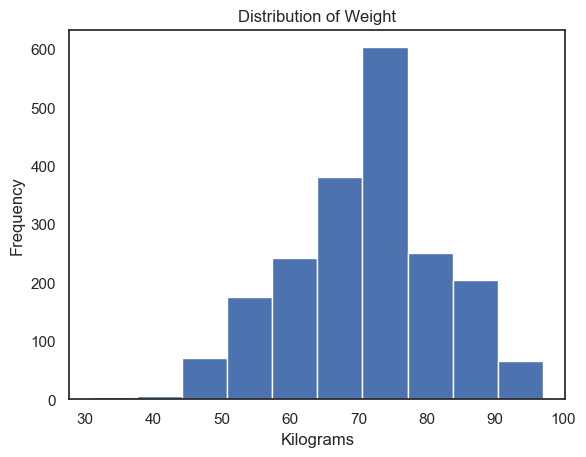

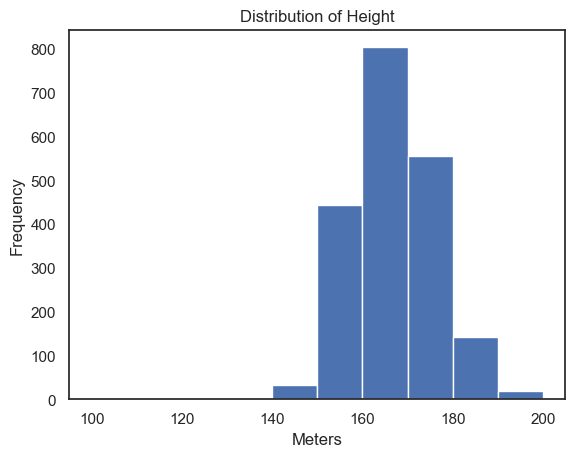

Text(0.5, 1.0, 'Distribution of BMI')

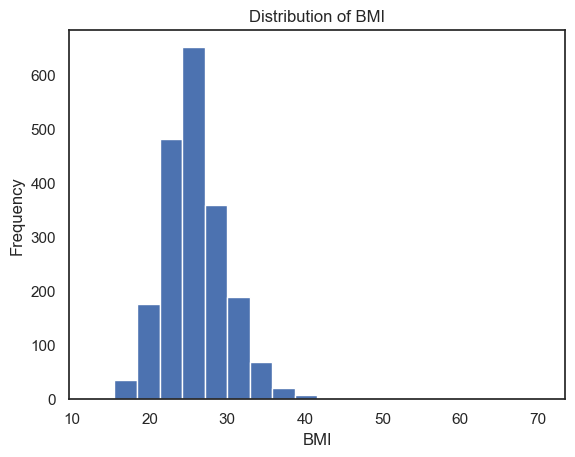

In [386]:
# Plot the distribution of weight
plt.hist(df_survey_imputed.id_bio_weight)
plt.xlabel("Kilograms")
plt.ylabel("Frequency")
plt.title("Distribution of Weight")
plt.show()

# Plot the distribution of height
plt.hist(df_survey_imputed.id_bio_height)
plt.xlabel("Meters")
plt.ylabel("Frequency")
plt.title("Distribution of Height")
plt.show()

# Calculate the BMI and plot its distribution
df_survey_imputed["id_bio_bmi"] = (
    df_survey_imputed["id_bio_weight"] /
    (df_survey_imputed["id_bio_height"] / 100) ** 2
)
plt.hist(df_survey_imputed.id_bio_bmi, bins=20)
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.title("Distribution of BMI")


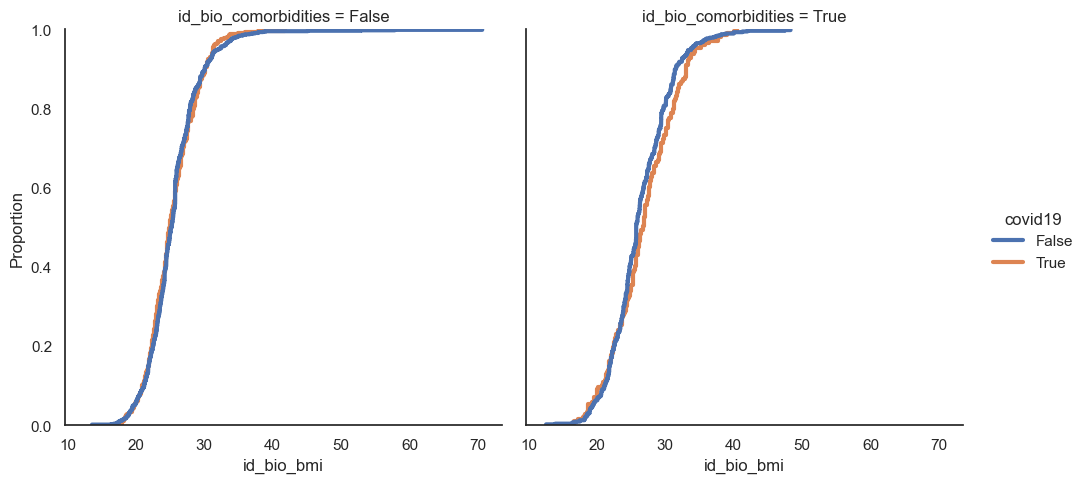

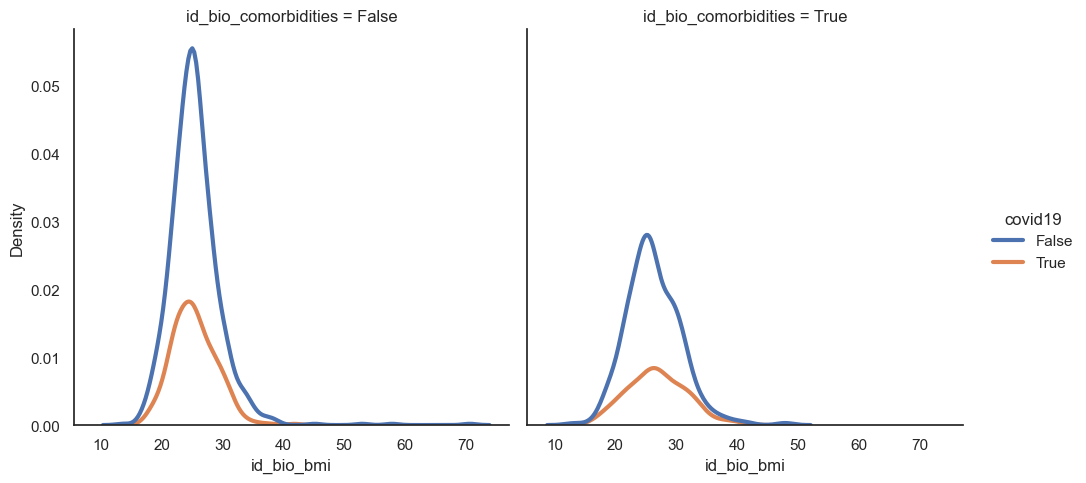

In [387]:
# Graph a plot between bmi and comobidities
df_tmp = pd.concat([df_survey["covid19"], df_survey_imputed], axis="columns")
# Change type of comorbidities to boolean
df_tmp["id_bio_comorbidities"] = df_tmp["id_bio_comorbidities"].astype(bool)

sns.displot(
    data=df_tmp,
    kind="ecdf",
    col="id_bio_comorbidities",
    x="id_bio_bmi",
    hue="covid19",
    linewidth=3,
)

sns.displot(
    data=df_tmp,
    kind="kde",
    col="id_bio_comorbidities",
    x="id_bio_bmi",
    hue="covid19",
    linewidth=3,
)


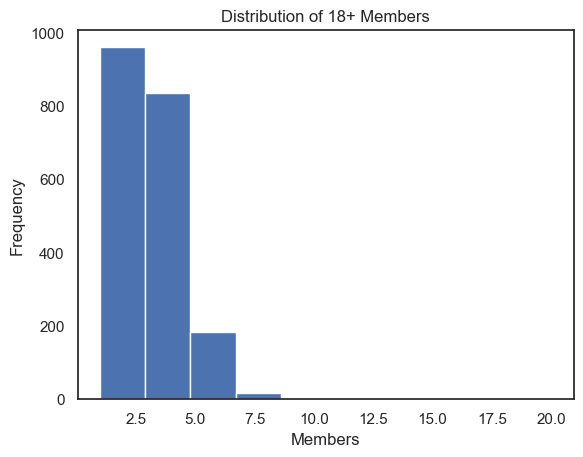

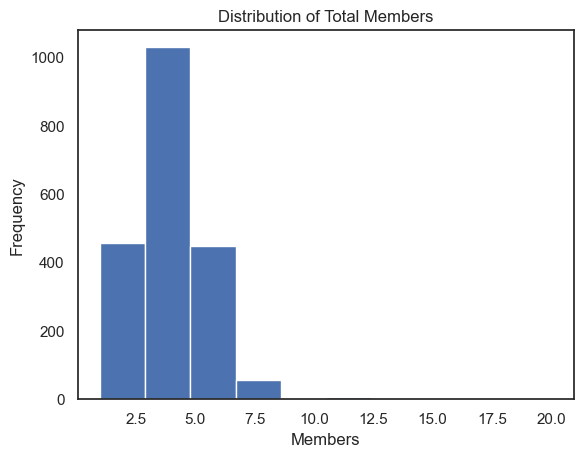

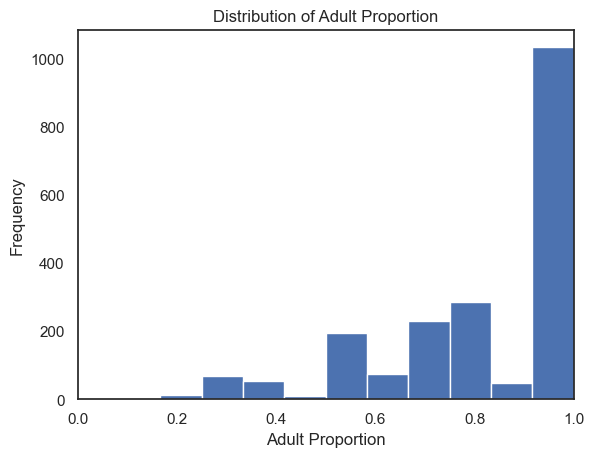

In [388]:
plt.hist(df_survey_imputed.id_mat_18_plus_household_members)
plt.xlabel("Members")
plt.ylabel("Frequency")
plt.title("Distribution of 18+ Members")
plt.show()

plt.hist(df_survey_imputed.id_mat_total_household_members)
plt.xlabel("Members")
plt.ylabel("Frequency")
plt.title("Distribution of Total Members")
plt.show()

df_survey_imputed["id_mat_adult_prop"] = (
    df_survey_imputed["id_mat_18_plus_household_members"]
    / df_survey_imputed["id_mat_total_household_members"]
)

df_survey_imputed = df_survey_imputed.assign(
    id_mat_adult_prop=lambda df: np.where(
        df["id_mat_adult_prop"] > 1, 1, df["id_mat_adult_prop"]
    )
)

plt.hist(df_survey_imputed.id_mat_adult_prop, bins=10)
plt.xlabel("Adult Proportion")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.title("Distribution of Adult Proportion")
plt.show()

In [389]:
# Clean unused variables

df_survey_imputed = df_survey_imputed.drop(
    columns=[
        "id_bio_weight",
        "id_bio_height",
        "id_mat_18_plus_household_members",
        "id_mat_total_household_members",
    ]
)
df_survey_imputed.head()

,id_bio_age,id_bio_disability,sd_occ_current_job,id_bio_bubble_contag,sd_inc_income_problems,id_bio_vacc_status,sd_cul_religion,id_beh_risk_personal,id_bio_comorbidities,id_beh_percep_contag,...,id_beh_percep_severity,id_bio_gender,id_psy_vacc_myths,sd_inc_income_level,sd_cul_holiday_season,sd_edu_scholarity,id_beh_risk_others,id_bio_out_bubble_contag,id_bio_bmi,id_mat_adult_prop
0,52.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,26.196187,1.000000
1,68.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,23.255019,1.000000
2,36.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,30.778701,0.666667
3,78.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,2.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,25.333333,1.000000
4,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,24.074074,1.000000


In [390]:
X_train, X_test, y_train, y_test = train_test_split(
    df_survey_imputed,
    df_survey[y],
    test_size=0.2,
    random_state=40,
    stratify=df_survey[y],
)


print("#" * 5 + " Split sample " + "#" * 5)
print("train:%d, test:%d" % (len(y_train.index), len(y_test.index)))
print("#" * 5 + " Distribution Train Sample " + "#" * 5)
print(y_train.value_counts() / len(y_train))
print("#" * 5 + " Distribution Test Sample " + "#" * 5)
print(y_test.value_counts() / len(y_test))

train = pd.concat([y_train, X_train], axis=1)
test = pd.concat([y_test, X_test], axis=1)


##### Split sample #####
train:1602, test:401
##### Distribution Train Sample #####
covid19
False    0.730961
True     0.269039
Name: count, dtype: float64
##### Distribution Test Sample #####
covid19
False    0.730673
True     0.269327
Name: count, dtype: float64


In [391]:
# Inicializar h2o
# h2o.cluster().shutdown()

h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 days 4 hours 57 mins
H2O_cluster_timezone:,America/Costa_Rica
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_maikol_vcm8ft
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.053 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [392]:
train.columns

Index(['covid19', 'id_bio_age', 'id_bio_disability', 'sd_occ_current_job',
       'id_bio_bubble_contag', 'sd_inc_income_problems', 'id_bio_vacc_status',
       'sd_cul_religion', 'id_beh_risk_personal', 'id_bio_comorbidities',
       'id_beh_percep_contag', 'id_beh_physical_act', 'id_psy_anxiety_sympt',
       'id_bio_death_covid', 'sd_eth_is_costa_rican', 'id_beh_percep_severity',
       'id_bio_gender', 'id_psy_vacc_myths', 'sd_inc_income_level',
       'sd_cul_holiday_season', 'sd_edu_scholarity', 'id_beh_risk_others',
       'id_bio_out_bubble_contag', 'id_bio_bmi', 'id_mat_adult_prop'],
      dtype='object')

In [393]:
# Convertir a h2o
col_types = {
    "covid19": "enum",
    "id_beh_percep_contag": "enum",
    "id_beh_percep_severity": "enum",
    "id_bio_bubble_contag": "enum",
    "id_bio_out_bubble_contag": "enum",
    "id_bio_death_covid": "enum",
    "id_beh_risk_personal": "enum",
    "id_beh_risk_others": "enum",
    "id_beh_physical_act": "enum",
    "id_psy_vacc_myths": "enum",
    "id_bio_vacc_status": "enum",
    "id_psy_anxiety_sympt": "enum",
    "sd_inc_income_problems": "enum",
    "sd_inc_income_level": "enum",
    "sd_cul_holiday_season": "enum",
    "id_bio_gender": "enum",
    "id_bio_age": "numeric",
    "id_bio_bmi": "numeric",
    #    "id_bio_weight": "numeric",
    #   "id_bio_height": "numeric",
    "sd_edu_scholarity": "enum",
    "sd_occ_current_job": "enum",
    "sd_eth_is_costa_rican": "enum",
    "id_bio_comorbidities": "enum",
    "sd_cul_religion": "enum",
    "id_bio_disability": "enum",
    "id_mat_adult_prop": "numeric",
    # "id_mat_18_plus_household_members": "numeric",
    # "id_mat_total_household_members": "numeric",
}

train_h2o = h2o.H2OFrame(train, column_types=col_types)
test_h2o = h2o.H2OFrame(test, column_types=col_types)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [394]:
train_h2o.types

{'covid19': 'enum',
 'id_bio_age': 'int',
 'id_bio_disability': 'enum',
 'sd_occ_current_job': 'enum',
 'id_bio_bubble_contag': 'enum',
 'sd_inc_income_problems': 'enum',
 'id_bio_vacc_status': 'enum',
 'sd_cul_religion': 'enum',
 'id_beh_risk_personal': 'enum',
 'id_bio_comorbidities': 'enum',
 'id_beh_percep_contag': 'enum',
 'id_beh_physical_act': 'enum',
 'id_psy_anxiety_sympt': 'enum',
 'id_bio_death_covid': 'enum',
 'sd_eth_is_costa_rican': 'enum',
 'id_beh_percep_severity': 'enum',
 'id_bio_gender': 'enum',
 'id_psy_vacc_myths': 'enum',
 'sd_inc_income_level': 'enum',
 'sd_cul_holiday_season': 'enum',
 'sd_edu_scholarity': 'enum',
 'id_beh_risk_others': 'enum',
 'id_bio_out_bubble_contag': 'enum',
 'id_bio_bmi': 'real',
 'id_mat_adult_prop': 'real'}

In [395]:
# max_models = 1000
# excluded_algos = ["StackedEnsemble", "DeepLearning"]

# # Definir modelo y entrenar
# aml = H2OAutoML(
#     # nfolds=10,
#     nfolds=-1,
#     max_models=max_models,
#     max_runtime_secs=3600,
#     seed=42,
#     stopping_metric="aucpr",
#     sort_metric="aucpr",
#     balance_classes=False,
#     exclude_algos=excluded_algos,
# )
# aml.train(y=y, training_frame=train_h2o)
# h2o.save_model(
#     aml.leader,
#     path="models/",
#     force=True,
#     filename="aml_leader_model",
#     export_cross_validation_predictions=True,
# )


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


'/Users/maikol/OneDrive/home/documents/2023/2023_03_paper_triageml_cr2021/Paper-COVID-MLTriage-CR2021/models/aml_leader_model'

In [396]:
if "aml" in locals() and isinstance(aml, h2o.automl.autoh2o.H2OAutoML):
    aml_leader = aml.leader
else:
    aml_leader = h2o.load_model("models/aml_leader_model")

In [397]:
aml_leader


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_9_20231004_120530_model_458


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    30                 30                          12273                  7            11           8.6           26            31            27.8333

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.11037461801193134
RMSE: 0.33222675691751763
LogLoss: 0.3518823482181848
Mean Per-Class Error: 0.16125488160316703
AUC: 0.9172044438192117
AUCPR: 0.8085222618148737
Gini: 0.8344088876384235

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18277565874433785
       False    True    Error    Rate
-----  -------  ------  -------  --------------
False  883      288     0.2459   (288.0/1171.0)
True   33       398     0.0766   (33.0/431.0)
Total  916      686     0.2004   (321.0/1602.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.182776     0.712623  261
max f2                       0.143542     0.83499   287
max f0point5                 0.603559     0.75124   93
max accuracy                 0.551681     0.850811  118
max precision                0.877328     1         0
max recall                   0.0940352    1         327
max specificity              0.877328     1         0
max absolute_mcc             0.180731     0.60739   262
max min_per_class_accuracy   0.298119     0.805104  220
max mean_per_class_accuracy  0.176883     0.839236  264
max tns                      0.877328     1171      0
max fns                      0.877328     430       0
max fps                      0.0223661    1171      399
max tps                      0.0940352    431       327
max tnr                      0.877328     1         0
max fnr                      0.877328     0.99768   0
max fpr                      0.0223661    1         399
max tpr                      0.0940352    1         327

Gains/Lift Table: Avg response rate: 26.90 %, avg score: 26.94 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0106117                   0.797175           3.71694    3.71694            1                0.820604   1                           0.820604            0.0394432       0.0394432                  271.694   271.694            0.0394432
2        0.0205993                   0.774155           3.48463    3.6043             0.9375           0.784254   0.969697                    0.80298             0.0348028       0.0742459                  248.463   260.43             0.073392
3        0.0305868                   0.75903            3.71694    3.64108            1                0.765145   0.979592                    0.790626            0.037123        0.111369                   271.694   264.108            0.110515
4        0.0405743                   0.737              3.71694    3.65975            1                0.74545    0.984615                    0.779505            0.037123        0.148492                   271.694   265.975            0.147638
5        0.0505618                   0.728872           3.71694    3.67105            1                

In [398]:
aml_leader.algo

'gbm'

In [399]:
aml_leader.save_model_details(
    path="models/", force=True, filename="aml_leader_model_details"
)


'/Users/maikol/OneDrive/home/documents/2023/2023_03_paper_triageml_cr2021/Paper-COVID-MLTriage-CR2021/models/aml_leader_model_details'

In [400]:
aml_leader.summary()

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,30.0,30.0,12273.0,7.0,11.0,8.6,26.0,31.0,27.833334


In [401]:
# Performance del modelo

perf = aml_leader.model_performance(test_data=test_h2o)
prevalence = sum(df_survey.covid19) / len(df_survey)
threshold = perf.F1()[0][0]
sensitivity = perf.recall(thresholds=[threshold])[0][1]
specificity = perf.specificity(thresholds=[threshold])[0][1]
F1 = perf.F1(thresholds=[threshold])[0][1]
AUC = perf.auc()
AUC_PR = perf.aucpr()
precision = perf.precision(thresholds=[threshold])[0][1]
accuracy = perf.accuracy(thresholds=[threshold])[0][1]


print("Prevalence", prevalence)
print("Threshold", threshold)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Accuracy:", accuracy)
print("F1:", F1)
print("AUC:", AUC)
print("AUC_PR:", AUC_PR)
print(perf.confusion_matrix(thresholds=[threshold]))


Prevalence 0.2690963554667998
Threshold 0.33386509863765595
Sensitivity: 0.8055555555555556
Specificity: 0.764505119453925
Precision: 0.5576923076923077
Accuracy: 0.7755610972568578
F1: 0.6590909090909091
AUC: 0.8083048919226394
AUC_PR: 0.5700166908012143
Confusion Matrix (Act/Pred) @ threshold = 0.33386509863765595
       False    True    Error    Rate
-----  -------  ------  -------  ------------
False  224      69      0.2355   (69.0/293.0)
True   21       87      0.1944   (21.0/108.0)
Total  245      156     0.2244   (90.0/401.0)


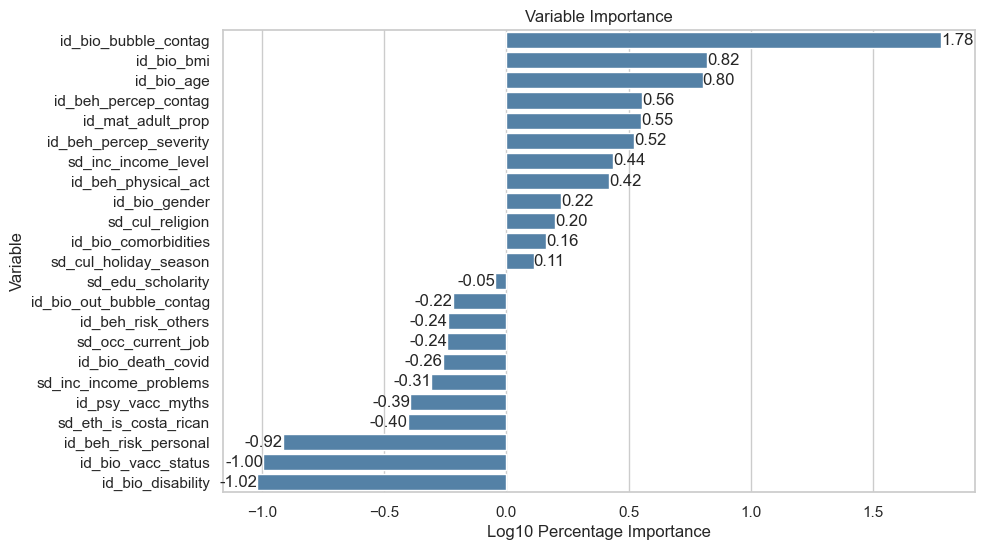

In [402]:
# Get variable importance data
var_imp = aml_leader.varimp(use_pandas=True)

# Filter only the variables with positive scaled_importance value
var_imp = var_imp[var_imp["percentage"] > 0]
var_imp["log_scaled_importance"] = np.log10(var_imp["percentage"] * 100)

h = 6
w = h * 1.618
# Create plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(w, h))  # set the figure size
ax = sns.barplot(
    x="log_scaled_importance", y="variable", data=var_imp, color="steelblue"
)
ax.bar_label(ax.containers[0], fmt="%.2f")

# Set informative labels for the plot
plt.title("Variable Importance")
plt.xlabel("Log10 Percentage Importance")
plt.ylabel("Variable")

# Set the x-axis limits to adjust the scale
# plt.xlim(0, 1)

# Save plot to pdf file
plt.savefig("img/plot_var_imp.pdf", bbox_inches="tight")
plt.show()

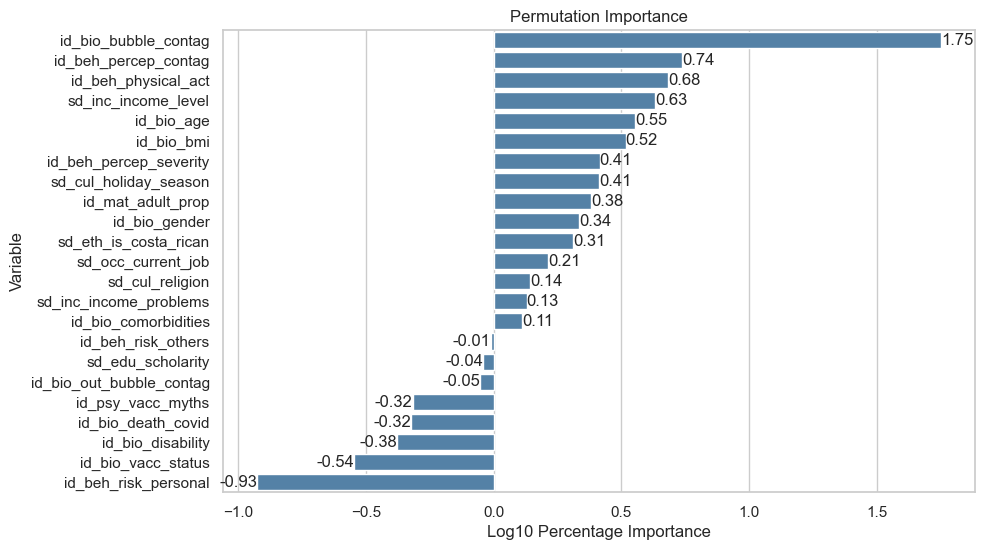

In [403]:
perm_imp = aml_leader.permutation_importance(
    frame=test_h2o, n_repeats=100, metric="PR_AUC", seed=42
)
perm_imp = perm_imp.as_data_frame()
perm_imp["mean"] = perm_imp[perm_imp.columns[1:]].mean(axis=1)
perm_imp = perm_imp.sort_values(by="mean", ascending=False)
perm_imp["Scaled Importance"] = perm_imp["mean"] / perm_imp["mean"].sum()

# perm_imp = perm_imp.as_data_frame()
perm_imp = perm_imp[perm_imp["Scaled Importance"] > 0]
perm_imp["log_scaled_importance"] = np.log10(perm_imp["Scaled Importance"] * 100)

h = 6
w = h * 1.618
# Create plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(w, h))  # set the figure size
ax = sns.barplot(
    x="log_scaled_importance", y="Variable", data=perm_imp, color="steelblue"
)
ax.bar_label(ax.containers[0], fmt="%.2f")

# Set informative labels for the plot
plt.title("Permutation Importance")
plt.xlabel("Log10 Percentage Importance")
plt.ylabel("Variable")

# Set the x-axis limits to adjust the scale
# plt.xlim(0, 1)

# Save plot to pdf file
plt.savefig("img/plot_perm_imp.pdf", bbox_inches="tight")
plt.show()

<Figure size 970.8x600 with 0 Axes>

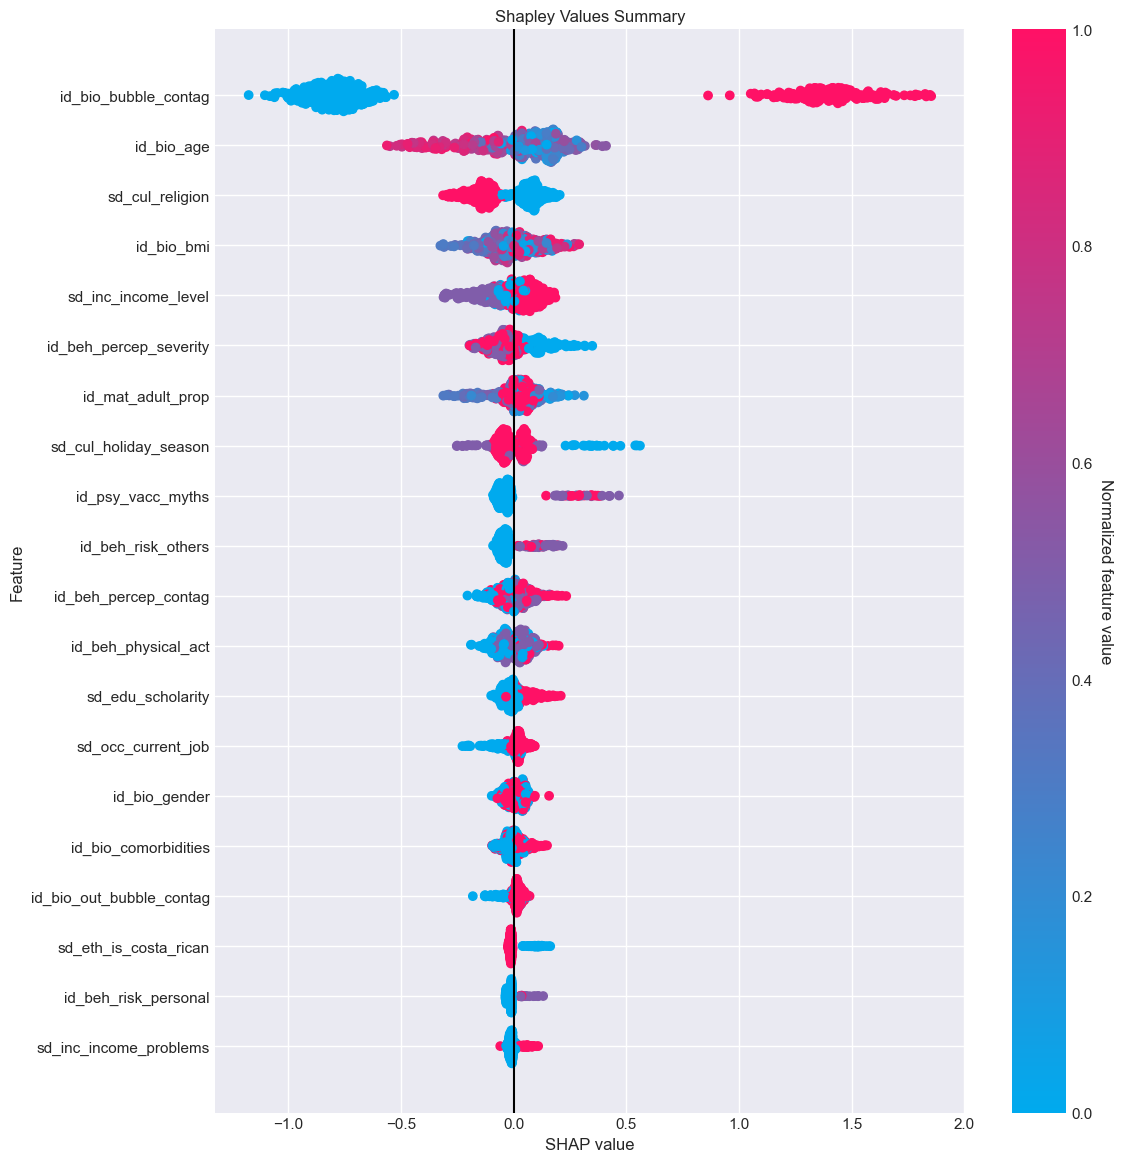

In [404]:
h = 6
w = h * 1.618
plt.rc("font", size=19)
plt.style.use("seaborn-v0_8-dark")
plt.figure(figsize=(w, h))  # set the figure size


shap_plot = aml_leader.shap_summary_plot(test_h2o, alpha=1, samples=3000)


plt.title("Shapley Values Summary")
plt.savefig("img/plot_shap.pdf", bbox_inches="tight")


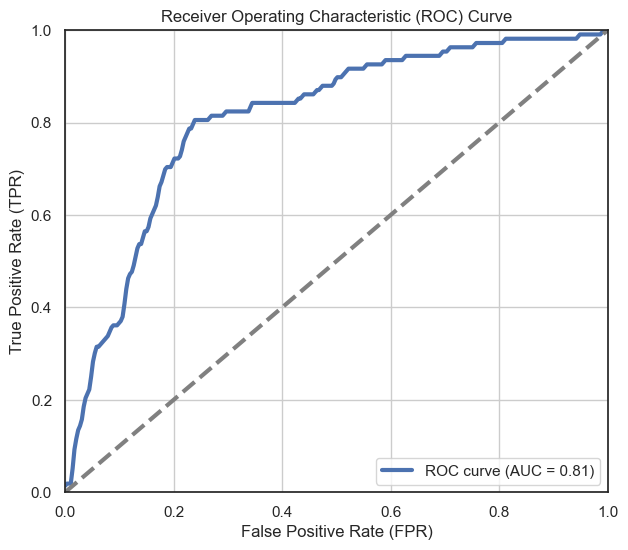

In [405]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

matplotlib.style.use("default")
fprs = perf.fprs
tprs = perf.tprs
auc = perf.auc()

df = pd.DataFrame({"fpr": fprs, "tpr": tprs})

sns.set_theme(style="white")
plt.figure(figsize=(7, 6))
sns.lineplot(
    x="fpr",
    y="tpr",
    lw=3,
    data=df,
    err_style=None,
    label="ROC curve (AUC = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="gray", lw=3, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("img/plot_roc.pdf", bbox_inches="tight")
plt.show()

In [406]:
precision = perf.precision(thresholds="all")
recall = perf.recall(thresholds="all")
pr_auc = perf.pr_auc()

precision = [t[1] for t in precision]
recall = [t[1] for t in recall]

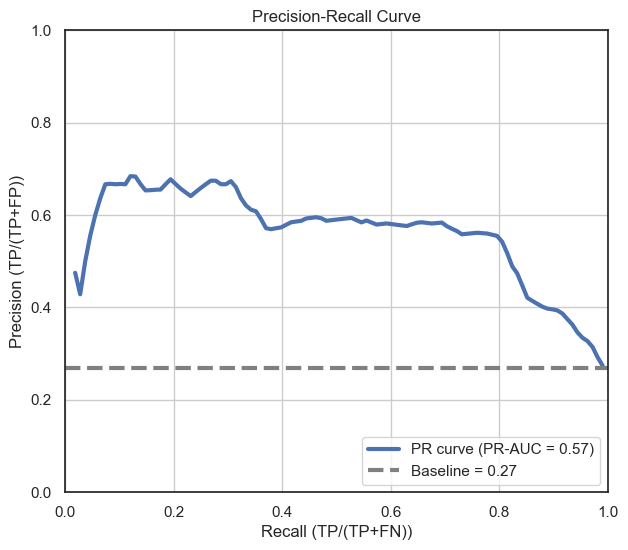

In [407]:
import seaborn as sns
import pandas as pd

precision = perf.precision(thresholds="all")
recall = perf.recall(thresholds="all")
pr_auc = perf.pr_auc()

precision = [t[1] for t in precision]
recall = [t[1] for t in recall]

df = pd.DataFrame({"Recall": recall, "Precision": precision})

df = df.query("Recall >0 & Recall < 1 & Precision >0 & Precision < 1")

sns.set_theme(style="white")
plt.figure(figsize=(7, 6))
sns.lineplot(
    x="Recall",
    y="Precision",
    lw=3,
    data=df,
    err_style=None,
    label="PR curve (PR-AUC = %0.2f)" % pr_auc,
)
plt.plot(
    [0, 1],
    [prevalence, prevalence],
    color="gray",
    lw=3,
    linestyle="--",
    label="Baseline = %0.2f" % prevalence,
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("Recall (TP/(TP+FN))")
plt.ylabel("Precision (TP/(TP+FP))")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("img/plot_pr.pdf", bbox_inches="tight")
plt.show()

In [408]:
# Variable importance
aml_leader.varimp(use_pandas=True)


,variable,relative_importance,scaled_importance,percentage
0,id_bio_bubble_contag,444.216797,1.000000,0.603305
1,id_bio_bmi,48.895710,0.110072,0.066407
2,id_bio_age,46.863457,0.105497,0.063647
3,id_beh_percep_contag,26.523037,0.059707,0.036022
4,id_mat_adult_prop,26.212273,0.059008,0.035600
5,id_beh_percep_severity,24.527325,0.055215,0.033311
6,sd_inc_income_level,20.073668,0.045189,0.027263
7,id_beh_physical_act,19.436329,0.043754,0.026397
8,id_bio_gender,12.346231,0.027793,0.016768
9,sd_cul_religion,11.646400,0.026218,0.015817


In [409]:
# Permutation importance
aml_leader.permutation_importance(
    frame=test_h2o, n_repeats=5, metric="PR_AUC", use_pandas=True
)


,Run 1,Run 2,Run 3,Run 4,Run 5
Variable,,,,,
id_bio_bubble_contag,0.268463,0.272548,0.282273,0.317086,0.298563
sd_inc_income_level,0.051000,0.025496,0.013033,0.019842,0.041669
id_beh_physical_act,0.038418,0.050034,0.034258,0.001777,0.009403
id_beh_percep_contag,0.034626,0.025804,0.040579,0.038752,0.017837
id_bio_age,0.024899,0.003555,0.004677,0.044796,0.005500
id_bio_bmi,0.024830,0.022778,0.001621,0.000307,0.024919
id_bio_gender,0.018092,0.008715,0.015825,0.012410,0.007387
id_beh_percep_severity,0.015668,0.001029,0.023836,0.034365,0.015783
sd_inc_income_problems,0.015097,0.000705,0.012127,0.013180,0.006683


Cálculo sin burbuja

In [410]:
# Guardar parametros
model_parameters = pd.DataFrame(
    {
        "prevalence": [prevalence],
        "threshold": [threshold],
        "sens_model": sensitivity,
        "spec_model": specificity,
        "people": test_h2o.nrow,
    }
)
print(model_parameters)
model_parameters.to_pickle(path="data/model_parameters.pkl")


   prevalence  threshold  sens_model  spec_model  people
0    0.269096   0.333865    0.805556    0.764505     401
